# Assignment Saskia Fohs
Welcome to the final assignment!
Here we will compare attention!
What will we do? We will take different parts of our task and look where the attention ended up. Especially the prestimulus period is extremely interesting for us: therefore we will only look at our transformers.

So some questions we will ask ourselves:
- did the model focus on prestimulus period in correctly differentiated trials of the training set? --> this would indicate overfitting
- did the model not focus on prestimulus period in correctly differentiated trials of the test set? --> this would indicate generalization
- did the model focus on prestimulus period in incorrectly differentiated trials of the test set? --> so has the prestimulus in these trials something that draws attention and therefore makes the model fail?

I will also look at two kinds of attention maps for the transformer model:
- GAP attention maps
- CLS attention maps

Since our model features both, both will be explored. The GAP attention maps will be created by averaging the attention maps over all heads and layers. The CLS attention maps will be created by taking the attention map of the last layer and the first head. This is done because the CLS token is the first token in the last layer and the first head. The CLS token is the token that is used for the classification of the image pair.

## Load data and model#
First we will load the data and the model. We will only use the transformer models for this analysis.

In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
sys.path.insert(0, '..')
import contrastive_eye_image.transformer_cl_model as tf
import contrastive_eye_image.cnn_cl_model as cnn
import matplotlib.pyplot as plt

Now we need our models and data. We will load the data from all sets and the models from all participants. Since, I did not succeed to get jupyter to run on the server without having to scp every 10 seconds, I will just load the data from my local machine.
The data can be found in the models folder on the server. As do the models.

In [2]:
def get_trials(model_path):
    with open(model_path + "/eval_test.pkl", 'rb') as f:
        eval_data_test = pickle.load(f)
    with open(model_path + "/eval_train.pkl", 'rb') as f:
        eval_data_train = pickle.load(f)
    return eval_data_train, eval_data_test

In [3]:
subj1_path = "../../models/sub1/tf/transformer_CL_2_1000_0-0003_50"
subj2_path = "../../models/sub2/tf/transformer_CL_2_1000_0-0003_50"

subj1_train, subj1_test = get_trials(subj1_path)
subj2_train, subj2_test = get_trials(subj2_path)

In [4]:
tf_subj1 = torch.load("../../models/sub2/tf/transformer_CL_2_1000_0-0003_50/checkpoint.pth", map_location=torch.device('cpu'))
tf_subj2 = torch.load("../../models/sub1/tf/transformer_CL_2_1000_0-0003_50/checkpoint.pth", map_location=torch.device('cpu'))

In [5]:
model_subj1 = tf.ContrastiveModel_tf()
model_subj2 = tf.ContrastiveModel_tf()

model_subj1.load_state_dict(tf_subj1['state_dict'])
# only eye encoder
model_subj1 = model_subj1.eye_encoder
model_subj1.eval()
model_subj2.load_state_dict(tf_subj2['state_dict'])
model_subj2 = model_subj2.eye_encoder
model_subj2.eval()

EyeTransformerEnc(
  (conv_projection): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
  (position_embedding): PositionalEncoding()
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x SelfAttention(
            (key): Linear(in_features=32, out_features=8, bias=False)
            (query): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_features=8, bias=False)
            (dropout): Dropout(p=0, inplace=False)
          )
        )
        (proj): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (feedforward): MLP(
        (net): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=32, bias=True)
          (3): Dropout(p=0, inplace=False)
        )
      )
      

## Forward hooks
Now we did not implement smart forward passes in our transformer: so now there a few options: forward hooks, or wrapping the model. I will go with forward hooks, since this is the most straightforward way.
I will extract two types of attention: GAP and CLS attention.
The CLS attention we define as the mean attention of the CLS to all other tokens, after QV and softmax, but before value scaling.

In [6]:
cls_per_trial = []
cls_per_pers = []

def hook_cls(m, i, o):
    """
    this hook takes the input from the self attention and returns the QV attention after softmax
    """
    x = i[0]
    batch_size, sequence_length, embedding_dim = x.shape

    # Calculate key, query, and value matrices
    keys = m.key(x)  # Shape: (batch_size, sequence_length, head_size)
    queries = m.query(x)  # Shape: (batch_size, sequence_length, head_size)

    # Compute attention scores by taking dot product of queries and keys
    # Scaled by square root of head_size to maintain stable gradients
    attention_scores = queries @ keys.transpose(-2, -1) * (embedding_dim ** -0.5)

    # Convert attention scores to probabilities
    attention_probs = F.softmax(attention_scores, dim=-1)

    # where does the cls token look? (- 1 because first is self attention)
    cls_attention = attention_probs[:, 0, 1:]
    # scale cls_attention to 0-1
    cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

    # append to list
    cls_per_trial.append(cls_attention.squeeze().detach().numpy())

This hook is a bit ugly, because we have to replicate the entire forward pass, of the transformer...
Here we measure how much each token participated in the GAP: aka abs mean of the context embeddings, collapsing the embedding dimension.

In [7]:
gap_per_pers = []
def hook_gap(m, i, o):
    batch_size, channels, sequence_length = i[0].shape

    # cls token for classification
    cls_token = torch.zeros(batch_size, 1, m.embedding_dim)

    # Create token embeddings
    token_embeddings = m.conv_projection(i[0])  # Shape: (batch_size, embedding_dim, sequence_length)
    # warning: dim needs to be swapped

    # this is annoying, but embedding dim and channel out need to be switched
    token_embeddings = torch.swapaxes(token_embeddings, 1,2) # Shape: (batch_size, sequence_length, embedding_dim)

    # concat cls token to embeddings
    token_embeddings = torch.cat((cls_token, token_embeddings), dim=1)  # Shape: (batch_size, sequence_length + 1, embedding_dim)

    # now it is on normal grounds, lets make it ugly for the function
    token_embeddings = torch.swapaxes(token_embeddings, 0, 1) # Shape: (sequence_length + 1, batch_size, embedding_dim)

    # apply positional encoding
    x = m.position_embedding(token_embeddings)

    # switch back to normal axes
    x = torch.swapaxes(x, 0, 1) # Shape: (batch_size, sequence_length + 1, embedding_dim)

    # Pass through stacked transformer blocks
    x = m.transformer_blocks(x)  # Shape: (batch_size, sequence_length + 1, embedding_dim)

    # Apply final layer normalisation
    x = m.layer_norm(x)  # Shape: (batch_size, sequence_length + 1, embedding_dim)

    x = x[:, 1:, :]  # Shape: (batch_size, sequence_length, embedding_dim)

    # gap for sequence embeddings
    x = torch.mean(torch.abs(x), dim=2).squeeze()  # Shape: (batch_size, sequence_length)

    # normalize
    x = (x - x.min()) / (x.max() - x.min())

    # append to list
    gap_per_pers.append(x.squeeze().detach().numpy())

In [8]:
# add hook
hook_registry = set()
for name, module in model_subj1.named_modules():
    if isinstance(module, tf.SelfAttention):
        module.register_forward_hook(hook_cls)
        hook_registry.add(module)
    if isinstance(module, tf.EyeTransformerEnc):
        module.register_forward_hook(hook_gap)
        hook_registry.add(module)

print(hook_registry)

# add hooks to subj2
for name, module in model_subj2.named_modules():
    if isinstance(module, tf.SelfAttention): #only add to self attention
        module.register_forward_hook(hook_cls)
    if isinstance(module, tf.EyeTransformerEnc): #only add to big model
        module.register_forward_hook(hook_gap)

{EyeTransformerEnc(
  (conv_projection): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
  (position_embedding): PositionalEncoding()
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x SelfAttention(
            (key): Linear(in_features=32, out_features=8, bias=False)
            (query): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_features=8, bias=False)
            (dropout): Dropout(p=0, inplace=False)
          )
        )
        (proj): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (feedforward): MLP(
        (net): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=32, bias=True)
          (3): Dropout(p=0, inplace=False)
        )
      )
     

## Attention in all trials
The models per participant are now seeing all trials they have seen in test and training tasks from the 2AFC again, to then look at the attention maps.
In the loop after each trial, the cls attention is meaned over the 4 attention heads of the model.
The GAP attention can remain, as there is only one per model.
Sorry, for the global variables...
WARNING: hooks are executed twice... I cant find out why. Registry is correct. Due to the call again in the gap hook, we have 8 instead of 4 times attention head hook call. But this doesnt matter, since it double the entries and length. So mean stays same. But it is annoying. Wrapping the original model, would be the goal for future use.

In [9]:
def get_attention(model, data):
    global gap_per_pers
    gap_per_pers = []
    global cls_per_pers
    cls_per_pers = []
    global cls_per_trial

    with torch.no_grad():
        for i in tqdm(range(len(data["eye_data"]))):
            cls_per_trial = []
            model(torch.from_numpy(data["eye_data"][i]).float().unsqueeze(0))
            cls_per_pers.append(np.mean(np.asarray(cls_per_trial), axis=0))
    return np.asarray(gap_per_pers), np.asarray(cls_per_pers)

In [10]:
gap_sub1_test, cls_sub1_test = get_attention(model_subj1, subj1_test)

100%|██████████| 5000/5000 [11:44<00:00,  7.10it/s] 


In [11]:
print(gap_sub1_test.shape)
print(cls_sub1_test.shape)

# dump
with open("gap_sub1_test.pkl", 'wb') as f:
    pickle.dump(gap_sub1_test, f)
with open("cls_sub1_test.pkl", 'wb') as f:
    pickle.dump(cls_sub1_test, f)

(5000, 1680)
(5000, 1680)


In [13]:
gap_sub1_train, cls_sub1_train = get_attention(model_subj1, subj1_train)
gap_sub2_test, cls_sub2_test = get_attention(model_subj2, subj2_test)
gap_sub2_train, cls_sub2_train = get_attention(model_subj2, subj2_train)

100%|██████████| 10000/10000 [15:12<00:00, 10.96it/s]


Now lets dump all.

In [14]:
with open("gap_sub1_train.pkl", 'wb') as f:
    pickle.dump(gap_sub1_train, f)
with open("cls_sub1_train.pkl", 'wb') as f:
    pickle.dump(cls_sub1_train, f)
with open("gap_sub2_test.pkl", 'wb') as f:
    pickle.dump(gap_sub2_test, f)
with open("cls_sub2_test.pkl", 'wb') as f:
    pickle.dump(cls_sub2_test, f)
with open("gap_sub2_train.pkl", 'wb') as f:
    pickle.dump(gap_sub2_train, f)
with open("cls_sub2_train.pkl", 'wb') as f:
    pickle.dump(cls_sub2_train, f)

In [15]:
# read all
with open("gap_sub1_test.pkl", 'rb') as f:
    gap_sub1_test = pickle.load(f)
with open("cls_sub1_test.pkl", 'rb') as f:
    cls_sub1_test = pickle.load(f)
with open("gap_sub1_train.pkl", 'rb') as f:
    gap_sub1_train = pickle.load(f)
with open("cls_sub1_train.pkl", 'rb') as f:
    cls_sub1_train = pickle.load(f)
with open("gap_sub2_test.pkl", 'rb') as f:
    gap_sub2_test = pickle.load(f)
with open("cls_sub2_test.pkl", 'rb') as f:
    cls_sub2_test = pickle.load(f)
with open("gap_sub2_train.pkl", 'rb') as f:
    gap_sub2_train = pickle.load(f)
with open("cls_sub2_train.pkl", 'rb') as f:
    cls_sub2_train = pickle.load(f)

Now lets first look at the general attention of the models and both kinds of attention.

## Focus in the Training data
Lets first look at the training data. We will look at the GAP attention and the CLS attention. We will only take correct trials.

In [18]:
subj1_corr_mask = np.array(subj1_train["label_true"]) > np.array(subj1_train["label_false"])
subj1_train_cls_corr = cls_sub1_train[subj1_corr_mask]
subj1_train_gap_corr = gap_sub1_train[subj1_corr_mask]

subj2_corr_mask = np.array(subj2_train["label_true"]) > np.array(subj2_train["label_false"])
subj2_train_cls_corr = cls_sub2_train[subj2_corr_mask]
subj2_train_gap_corr = gap_sub2_train[subj2_corr_mask]

cls_list = [subj1_train_cls_corr, subj2_train_cls_corr]
gap_list = [subj1_train_gap_corr, subj2_train_gap_corr]

In [44]:
def plot_attention(cls_list, gap_list):
    time_x = np.arange(0, 1680, 1) / 1200 - 0.1
    subjs = ["Subj1", "Subj2"]
    for i in range(2):
        # make subplot
        fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        # set fig title
        fig.suptitle(f"{subjs[i]}")
        ax[0].plot(time_x, cls_list[i].mean(axis=0))
        ax[0].set_title("CLS Attention")
        ax[0].set_xlabel("Time")
        ax[0].set_ylabel("Attention")
        ax[0].axvline(x=0, color='r', linestyle='--')
        ax[1].plot(time_x, gap_list[i].mean(axis=0))
        ax[1].set_title("GAP Attention")
        ax[1].set_xlabel("Time")
        ax[1].axvline(x=0, color='r', linestyle='--')
        ax[0].set_ylim([0, 1])
        plt.show()

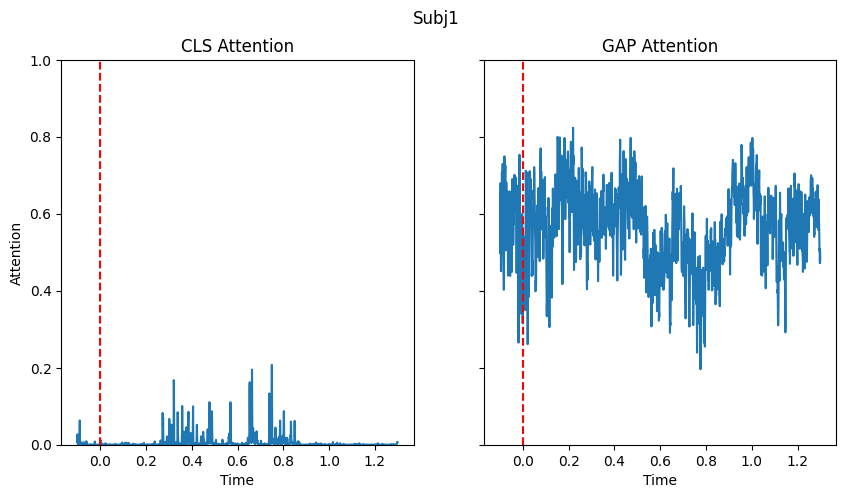

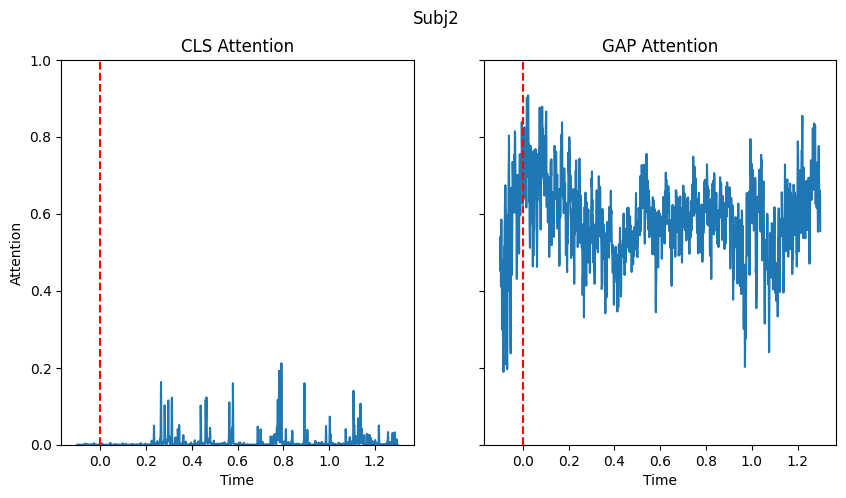

In [45]:
plot_attention(cls_list, gap_list)

The good and the bad:
- the CLS attention is really low in the prestimulus period. This is good, because the model should not focus on the prestimulus period. This is the case for both models.
- the GAP attention is really farspread, but it has to be said, that this measure is by far not as precise about attention, since it just says something about the contribution of the token to the context embeddings. But it is interesting to see, that the GAP attention is really high in the prestimulus period. This is the case for both models. Also subject 2 has a smaller GAP attention in the prestimulus period.

## Focus in the Test data of correct trials

In [46]:
subj1_corr_mask = np.array(subj1_test["label_true"]) > np.array(subj1_test["label_false"])
subj1_test_cls_corr = cls_sub1_test[subj1_corr_mask]
subj1_test_cls_inc = cls_sub1_test[~subj1_corr_mask]
subj1_test_gap_corr = gap_sub1_test[subj1_corr_mask]
subj1_test_gap_inc = gap_sub1_test[~subj1_corr_mask]

subj2_corr_mask = np.array(subj2_test["label_true"]) > np.array(subj2_test["label_false"])
subj2_test_cls_corr = cls_sub2_test[subj2_corr_mask]
subj2_test_cls_inc = cls_sub2_test[~subj2_corr_mask]
subj2_test_gap_corr = gap_sub2_test[subj2_corr_mask]
subj2_test_gap_inc = gap_sub2_test[~subj2_corr_mask]

cls_list_corr = [subj1_test_cls_corr, subj2_test_cls_corr]
cls_list_inc = [subj1_test_cls_inc, subj2_test_cls_inc]
gap_list_corr = [subj1_test_gap_corr, subj2_test_gap_corr]
gap_list_inc = [subj1_test_gap_inc, subj2_test_gap_inc]

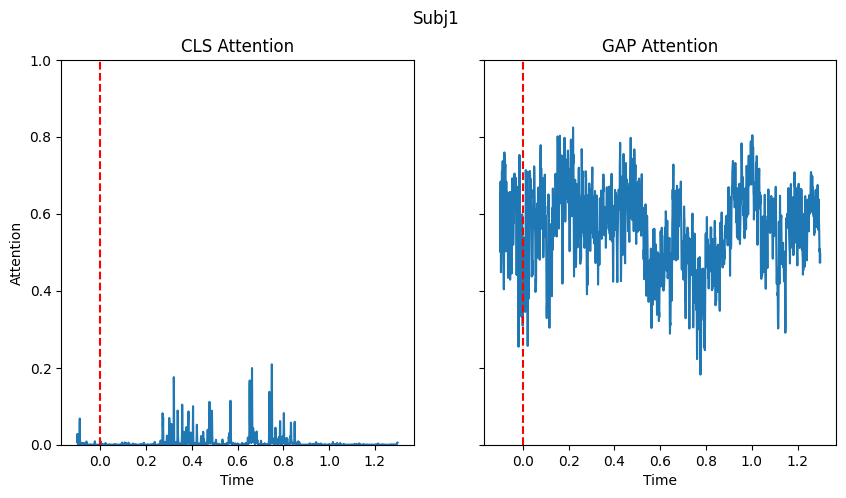

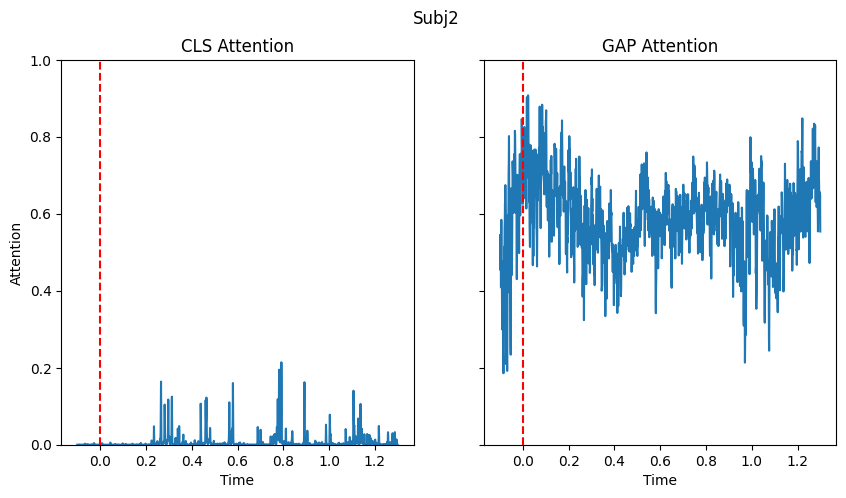

In [47]:
plot_attention(cls_list_corr, gap_list_corr)

This looks exactly the same, as the training attention. Lets first look at the attention in the incorrect trials and then draw our conclusions.

## Focus in the Test data of incorrect trials

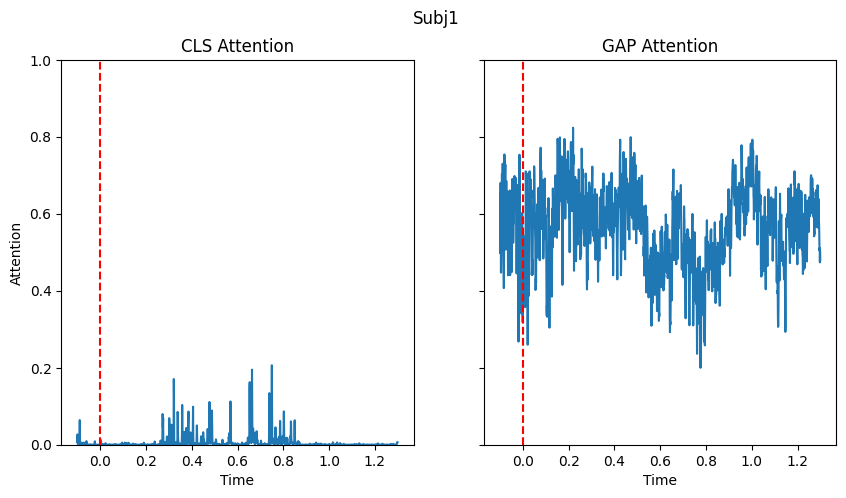

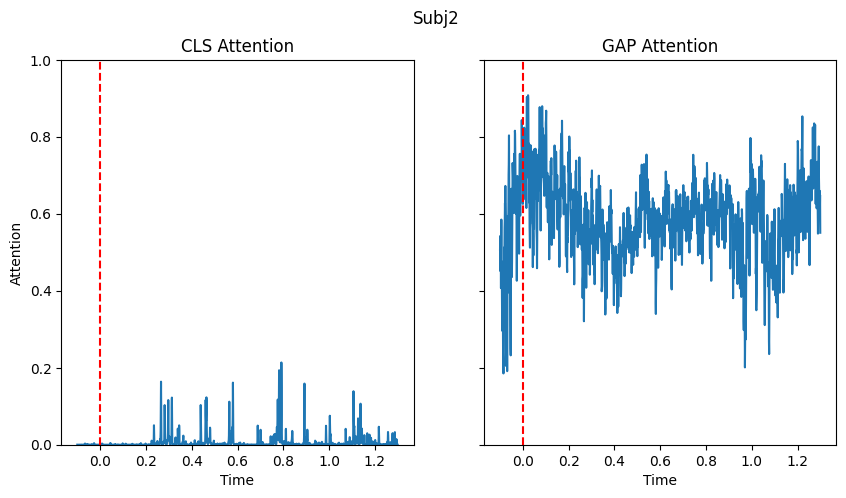

In [48]:
plot_attention(cls_list_inc, gap_list_inc)

Now this looks exactly the same as before. Why is that? The attention maps are not exactly the same. They do not perfectly correlate (but nearly...). But the general trend is the same. The model does not focus on the prestimulus period in the CLS attention. But it does in the GAP attention.

In [37]:
# correlate
print(np.corrcoef(subj1_test_gap_inc.mean(axis=0), subj1_train_gap_corr.mean(axis=0)))

[[1.         0.99974251]
 [0.99974251 1.        ]]


One thought I have is: overfitting. But not in the classical sense, that we get worse in the test and better in the train set. But in the sense, that we overlearn specific periods, that are indicative of image identity in all cases.
So we might have found a systematic, but since we did not use dropout in the current models, we might have just extremly amplified signal periods. But still: those seem to be indicative of image identity, since we see some accuracy in the test set (see evaluation).

So all in all: back to the drawing board. But not completely. Only for the dropout and data augmentations, to enable a more diverse learning.